## Area Level Cyclability

### Structure

- Get LSOAs / local authority boundaries
- For a single LSOA
    - Get historical data (2016 vs 2021)
    - Some quality checks on data
    - Calculate LTS 2016 vs 2021
    - Analyse impact over time
- Network measures using LTS
    - Connectivity at different LTS levels
    - Other graph measures, separate research to bring in idea/insights for this section

In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from shapely.ops import transform
from functools import partial
import pyproj


#Below function from ChatGPT
#Get expanded network - method 1 km buffer
def expand_bbox(original_bbox, expansion_distance_km=5):
    # Create a Shapely geometry object for the original bounding box
    original_geometry = box(*original_bbox)

    # Define a function to project the geometry to a new coordinate reference system
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # WGS 84 coordinate reference system
        pyproj.Proj(proj='utm', zone=33, ellps='WGS84')  # Example: UTM Zone 33
    )

    # Project the original geometry to the new coordinate reference system
    projected_geometry = transform(project, original_geometry)

    # Calculate the expansion distance in the projected coordinate system
    expansion_distance_meters = expansion_distance_km * 1000

    # Expand the geometry by the specified distance
    expanded_geometry = projected_geometry.buffer(expansion_distance_meters)

    # Project the expanded geometry back to the original coordinate reference system
    expanded_geometry = transform(partial(pyproj.transform, pyproj.Proj(proj='utm', zone=33, ellps='WGS84'), pyproj.Proj(init='epsg:4326')), expanded_geometry)

    # Get the coordinates of the expanded bounding box
    expanded_bbox = expanded_geometry.bounds

    return expanded_bbox, expanded_geometry

In [83]:
# Import MSOA lookup
msoas = gpd.read_file('data/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp').to_crs(4326).set_index('msoa11cd')

In [4]:
# Import MSOA 2011 OD data
od_data = pd.read_parquet('data/od_2011.parquet')

In [5]:
#Import LSOAs

lsoas = gpd.read_file('data/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4_6029841263726194941.gpkg').to_crs(4326)
lsoas = pd.concat([lsoas, lsoas.bounds], axis=1)

In [6]:
#Import lsoa to msoa look up

lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')

/tmp/ipykernel_159026/4023548689.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')


In [23]:
test_lsoa = lookup[lookup['PCD8'] == 'SE15 5PD']

### Select a test LSOA

In [24]:
lsoa = lsoas[lsoas['LSOA11CD'] == test_lsoa['LSOA11CD'].values[0]]

### Get data from 2016 and 2021 to make some high level comparisons

In [21]:
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016 = ox.graph_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016 = ox.graph_to_gdfs(G_2016, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021 = ox.graph_from_bbox(lsoa['maxy'],lsoa['miny'],lsoa['minx'],lsoa['maxx'],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021 = ox.graph_to_gdfs(G_2021, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [25]:
#Get expanded network

original_bbox = (lsoa['minx'], lsoa['miny'], lsoa['maxx'], lsoa['maxy'])  # Replace with your original bounding box coordinates
expanded_bbox, expanded_geometry = expand_bbox(original_bbox, expansion_distance_km=0.5)
print("Original Bounding Box:", original_bbox)
print("Expanded Bounding Box:", expanded_bbox)

bbox_original = box(lsoa['minx'], lsoa['miny'], lsoa['maxx'], lsoa['maxy'])
gpd.GeoSeries([bbox_original]).to_file('data/outputs/box_orig.geojson', driver='GeoJSON')

box_expanded = box(expanded_bbox[2],expanded_bbox[1],expanded_bbox[0],expanded_bbox[3])
gpd.GeoSeries([box_expanded]).to_file('data/outputs/box_expanded.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016_exp_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016_exp_buffer = ox.graph_to_gdfs(G_2016_exp_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016_exp_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016_exp_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016_exp_buffer.geojson', driver='GeoJSON')

ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021_exp_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021_exp_buffer = ox.graph_to_gdfs(G_2021_exp_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021_exp_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021_exp_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021_exp_buffer.geojson', driver='GeoJSON')

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib

Original Bounding Box: (3968   -0.078855
Name: minx, dtype: float64, 3968    51.470099
Name: miny, dtype: float64, 3968   -0.072779
Name: maxx, dtype: float64, 3968    51.474253
Name: maxy, dtype: float64)
Expanded Bounding Box: (-0.0859587591454154, 51.465662202760164, -0.0656751384452257, 51.47868943075723)


In [ ]:
#Get expanded network - method 2 use 2011 OD data - expanded box and/or coridor/buffer approach

In [26]:
test_lsoa

,PCD7,PCD8,OA11CD,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,LAD11NMW,PCDOASPLT
56984,SE155PD,SE15 5PD,E00020481,E01004066,Southwark 025E,E02000831,Southwark 025,E09000028,Southwark,NaN,0


In [48]:
bike_ods = od_data[(od_data['geo_code1'] == test_lsoa['MSOA11CD'].values[0]) & (od_data['bicycle'] > 0)][['geo_code2','bicycle']].set_index('geo_code2')
bike_ods['geometry'] = msoas['geometry']
bike_ods = bike_ods.dropna()

In [50]:
bike_ods_gdf = gpd.GeoDataFrame(bike_ods, crs="EPSG:4326", geometry=bike_ods['geometry'])
bike_ods_gdf.to_file('data/outputs/od_bike.geojson', driver='GeoJSON')

In [ ]:
#Get bounding box over LSOA and MSOA with highest commuter count

In [85]:
origin_geom = lsoa['geometry'].values[0]

In [86]:
destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']

In [73]:
from shapely.geometry import Polygon, MultiPolygon
def create_bounding_box(multipolygon1, multipolygon2):
    # Create Shapely geometry objects for each multipolygon
    geometry1 = MultiPolygon(multipolygon1)
    geometry2 = MultiPolygon(multipolygon2)

    # Calculate the union of all polygons in each multipolygon
    union_geometry1 = geometry1.convex_hull
    union_geometry2 = geometry2.convex_hull

    # Calculate the union of the convex hulls of the two multipolygons
    union_geometry = union_geometry1.union(union_geometry2)

    # Get the bounding box of the union geometry
    bounding_box = union_geometry.bounds

    return bounding_box


In [87]:
bounding_box_od = create_bounding_box(origin_geom, destination_geom)

In [88]:
od_box = box(bounding_box_od[2],bounding_box_od[1],bounding_box_od[0],bounding_box_od[3])
gpd.GeoSeries([od_box]).to_file('data/outputs/box_od.geojson', driver='GeoJSON')

In [90]:
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2016-06-01T01:00:00Z"]'
G_2016_od_buffer = ox.graph_from_bbox(bounding_box_od[3],bounding_box_od[1],bounding_box_od[2],bounding_box_od[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2016_od_buffer = ox.graph_to_gdfs(G_2016_od_buffer, nodes=True)[1]

In [91]:
edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2016_od_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2016_od_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2016_od_buffer.geojson', driver='GeoJSON')

In [93]:
ox.settings.overpass_settings = '[out:json][timeout:90][date:"2021-06-01T01:00:00Z"]'
G_2021_od_buffer = ox.graph_from_bbox(expanded_bbox[3],expanded_bbox[1],expanded_bbox[2],expanded_bbox[0],network_type = 'bike',retain_all=True,simplify=False)
edge_attributes_2021_od_buffer = ox.graph_to_gdfs(G_2021_od_buffer, nodes=True)[1]

edge_attributes_gdf = gpd.GeoDataFrame(edge_attributes_2021_od_buffer[['osmid','geometry']], crs="EPSG:4326", geometry=edge_attributes_2021_od_buffer['geometry'])
edge_attributes_gdf.to_file('data/outputs/lsoa_example_2021_od_buffer.geojson', driver='GeoJSON')

In [ ]:
# Next Steps

# Analysis of this then now data at all three levels
# Measure LTS at all three levels and devise single metric (e.g., percentgae increase in LTS 1 and 2)
# Routing Analysis
# Network centrality

In [ ]:
#link to MSOA geoms


In [ ]:

#Output



In [ ]:

#Visualise

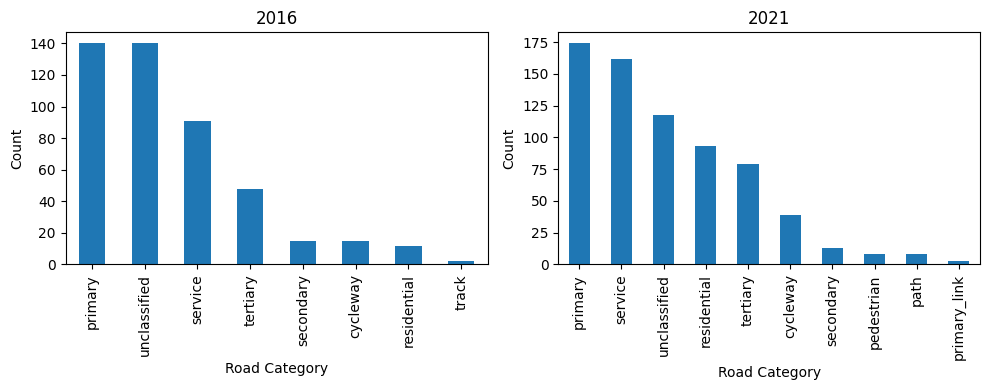

In [6]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016['highway'].value_counts()
value_counts_2021 = edge_attributes_2021['highway'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Road Category')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Road Category')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

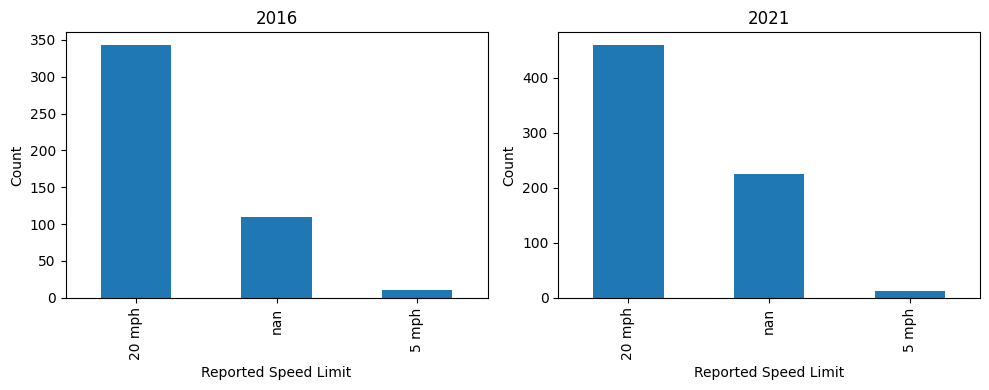

In [7]:
# Use value_counts to get counts of each category
value_counts_2016 = edge_attributes_2016['maxspeed'].value_counts(dropna = False)
value_counts_2021 = edge_attributes_2021['maxspeed'].value_counts(dropna = False)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

value_counts_2016.plot(kind='bar', ax = axs[0])
axs[0].set_xlabel('Reported Speed Limit')
axs[0].set_ylabel('Count')
axs[0].set_title('2016')

value_counts_2021.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Reported Speed Limit')
axs[1].set_ylabel('Count')
axs[1].set_title('2021')

plt.tight_layout()
plt.show()

In [ ]:
# Get LTS

#todo
#Adapt OSM